In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pickle
import copy
import itertools
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# from tqdm import tqdm
from xtx_model import BaseMLP, ConditionMLP
from xtx_config import XTX_Config
from core.losses import tf_score_loss, score, model_score, Score
from core.model_utils import HyperFinder
from core.dataset_utils import data_sliding
from core.dataset_utils import split_data

import dataset as dt

## load data

In [3]:
# load dataset
dataset = dt.XTXDataset()
dataset.delete_invalid_rows()

Time series length: 2999999


In [ ]:
levels = 7
discrete_levels = 16
sampling = 5

sx, sy = data_sliding(dataset.features, dataset.label_y, time_step=15)

nb_test = sx.shape[0] // sampling
res = np.zeros((nb_test, sx.shape[1], discrete_levels*2), dtype=np.float32)
for i in np.arange(nb_test):
    if i % 10000 == 0:
        print("%s/%s" %(i, nb_test))
    center = sx[i*sampling, -1, 0]
    for j in range(sx.shape[1]):
        # get data
        ask_rate = sx[i*sampling, j, 0:levels]
        ask_size = sx[i*sampling, j, 15:15+levels]
        bid_rate = sx[i*sampling, j, 30:30+levels]
        bid_size = sx[i*sampling, j, 45:45+levels]
        
        # ask
        ask_inds = np.int32((ask_rate - center) // 0.5)
        flag = (ask_inds < discrete_levels) & (ask_inds >= -discrete_levels)
        # preserve index in bound
        ask_size = ask_size[flag]
        ask_inds = discrete_levels - ask_inds[flag] - 1
        #
        res[i, j][ask_inds] = np.log10(ask_size+1)
        
        # bid
        bid_inds = np.int32((bid_rate - center) // 0.5)
        flag = (bid_inds < discrete_levels) & (bid_inds >= -discrete_levels)
        # preserve index in bound
        bid_size = bid_size[flag]
        bid_inds = discrete_levels - bid_inds[flag] - 1
        #
        res[i, j][bid_inds] = -np.log10(bid_size+1)

(train_x, train_y), (val_x, val_y), (test_x, test_y) = split_data([res, dataset.label_y[14:][:nb_test*sampling:sampling]], split=[0.6, 0.1, 0.3], sampling=1)

In [23]:
mid_rate = dataset.mid_rate
y = dataset.label_y
(train_x, train_y), (val_x, val_y), (test_x, test_y) = split_data([mid_rate, y], split=[0.6, 0.1, 0.3], sampling=5)

def y_norm(_y, n=87):
    res = np.zeros(len(_y)-2*n)
    for i in range(2*n, len(_y)):
        res[i-2*n] = _y[i] - np.mean(_y[i-2*n:i-n+1])
    return np.std(res)

def compare(process_func):
    for data, name in zip([train_y, val_y, test_y], ['train', 'val', 'test']):
        value = process_func(data)
        print('%s: %.5f'%(name, value))

### MLP

In [4]:
from xtx_config import XTX_Config
from core.dataset_utils import volume_data

In [5]:
mlp_model = BaseMLP(XTX_Config)
# mlp_model = ConditionMLP(XTX_Config)
mlp_model.set_data(dataset, data_func=volume_data)
# (train_x, train_y), (val_x, val_y), (test_x, test_y) = mlp_model._parse_datas()

In [19]:
json_string = mlp_model._model.to_json()

In [20]:
json_string

'{"class_name": "Model", "config": {"name": "model_1", "layers": [{"name": "input_2", "class_name": "InputLayer", "config": {"batch_input_shape": [null, 15, 10], "dtype": "float32", "sparse": false, "name": "input_2"}, "inbound_nodes": []}, {"name": "flatten_1", "class_name": "Flatten", "config": {"name": "flatten_1", "trainable": true, "dtype": "float32", "data_format": "channels_last"}, "inbound_nodes": [[["input_2", 0, 0, {}]]]}, {"name": "dense_5", "class_name": "Dense", "config": {"name": "dense_5", "trainable": true, "dtype": "float32", "units": 64, "activation": "linear", "use_bias": false, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": {"class_name": "L1L2", "config": {"l1": 0.0, "l2": 0.0}}, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}, "inbound_nodes": [[["flatten_1", 0, 0, {}]]]}, {"name": "leaky_re_

In [22]:
mlp_model._model.history.history

{'loss': [6.669522166413756,
  1.547284964029505,
  1.2077871837553014,
  1.0914574317529615,
  1.045983232872237,
  1.0232428213580989,
  1.014248193021726,
  1.009628093576748,
  1.0081564024422949,
  1.0066615932529799,
  1.0066648433349048,
  1.0060303866395612,
  1.0055365761867392,
  1.0059266729480763,
  1.0053587784630542,
  1.004659209583811,
  1.004249316546534,
  1.004416342186249,
  1.00421323438009,
  1.0041109879686194,
  1.00403494113492,
  1.0035723951100122,
  1.003103005772944,
  1.0030015422193939,
  1.0031562105960161,
  1.0027269352603927,
  1.0017826824706688,
  1.001633934121741,
  1.0019192889058217,
  1.0009414580150595,
  1.0010307475613507,
  1.0003356635868597,
  0.9999960704810292,
  0.9997385391949405,
  0.9995077141784311,
  0.9992778125364707,
  0.9987866278925981,
  0.9983375748554069,
  0.998080001137456,
  0.9983004006096753,
  0.9982099965493921,
  0.997623576924082,
  0.9979730904138093,
  0.9967970329442409,
  0.9974740726998178,
  0.99714539732933

In [ ]:
batch_size, epochs, callbacks = mlp_model._parse_args(["batch_size", "epochs", "callbacks"])
mlp_model.compile()
mlp_model._model.fit(train_x, train_y, batch_size=batch_size, epochs=epochs, validation_data=(val_x, val_y), callbacks=callbacks)

In [6]:
history = mlp_model.retrain()

Train on 359944 samples, validate on 59990 samples
Epoch 1/320
359944/359944 [==============================] - 6s 17us/sample - loss: 6.6695 - tf_score_metric: -5.6408 - val_loss: 1.1630 - val_tf_score_metric: -0.0835
Epoch 2/320
359944/359944 [==============================] - 5s 15us/sample - loss: 1.5473 - tf_score_metric: -0.5417 - val_loss: 1.0897 - val_tf_score_metric: -0.0122
Epoch 3/320
359944/359944 [==============================] - 5s 14us/sample - loss: 1.2078 - tf_score_metric: -0.2030 - val_loss: 1.0782 - val_tf_score_metric: -0.0020
Epoch 4/320
359944/359944 [==============================] - 5s 14us/sample - loss: 1.0915 - tf_score_metric: -0.0872 - val_loss: 1.0766 - val_tf_score_metric: -2.5692e-04
Epoch 5/320
359944/359944 [==============================] - 5s 14us/sample - loss: 1.0460 - tf_score_metric: -0.0420 - val_loss: 1.0757 - val_tf_score_metric: 3.0527e-04
Epoch 6/320
359944/359944 [==============================] - 5s 14us/sample - loss: 1.0232 - tf_score_

359944/359944 [==============================] - 5s 14us/sample - loss: 0.9962 - tf_score_metric: 0.0076 - val_loss: 1.0563 - val_tf_score_metric: 0.0187
Epoch 50/320
359944/359944 [==============================] - 5s 14us/sample - loss: 0.9966 - tf_score_metric: 0.0075 - val_loss: 1.0536 - val_tf_score_metric: 0.0215
Epoch 51/320
359944/359944 [==============================] - 5s 14us/sample - loss: 0.9964 - tf_score_metric: 0.0079 - val_loss: 1.0542 - val_tf_score_metric: 0.0210
Epoch 52/320
359944/359944 [==============================] - 5s 14us/sample - loss: 0.9956 - tf_score_metric: 0.0080 - val_loss: 1.0548 - val_tf_score_metric: 0.0207
Epoch 53/320
359944/359944 [==============================] - 5s 14us/sample - loss: 0.9955 - tf_score_metric: 0.0084 - val_loss: 1.0556 - val_tf_score_metric: 0.0196
Epoch 54/320
359944/359944 [==============================] - 5s 14us/sample - loss: 0.9960 - tf_score_metric: 0.0074 - val_loss: 1.0710 - val_tf_score_metric: 0.0069
Epoch 55/32

359944/359944 [==============================] - 5s 14us/sample - loss: 0.9930 - tf_score_metric: 0.0112 - val_loss: 1.0482 - val_tf_score_metric: 0.0267
Epoch 99/320
359944/359944 [==============================] - 5s 14us/sample - loss: 0.9922 - tf_score_metric: 0.0117 - val_loss: 1.0489 - val_tf_score_metric: 0.0260
Epoch 100/320
359944/359944 [==============================] - 5s 14us/sample - loss: 0.9925 - tf_score_metric: 0.0113 - val_loss: 1.0491 - val_tf_score_metric: 0.0266
Epoch 101/320
359944/359944 [==============================] - 5s 14us/sample - loss: 0.9925 - tf_score_metric: 0.0112 - val_loss: 1.0476 - val_tf_score_metric: 0.0271
Epoch 102/320
359944/359944 [==============================] - 5s 14us/sample - loss: 0.9926 - tf_score_metric: 0.0115 - val_loss: 1.0484 - val_tf_score_metric: 0.0268
Epoch 103/320
359944/359944 [==============================] - 5s 14us/sample - loss: 0.9927 - tf_score_metric: 0.0112 - val_loss: 1.0473 - val_tf_score_metric: 0.0278
Epoch 1

Epoch 147/320
359944/359944 [==============================] - 5s 14us/sample - loss: 0.9913 - tf_score_metric: 0.0128 - val_loss: 1.0482 - val_tf_score_metric: 0.0268
Epoch 148/320
359944/359944 [==============================] - 5s 14us/sample - loss: 0.9913 - tf_score_metric: 0.0127 - val_loss: 1.0482 - val_tf_score_metric: 0.0273
Epoch 149/320
359944/359944 [==============================] - 5s 14us/sample - loss: 0.9913 - tf_score_metric: 0.0126 - val_loss: 1.0483 - val_tf_score_metric: 0.0268
Epoch 150/320
359944/359944 [==============================] - 5s 14us/sample - loss: 0.9908 - tf_score_metric: 0.0130 - val_loss: 1.0461 - val_tf_score_metric: 0.0284
Epoch 151/320
359944/359944 [==============================] - 5s 14us/sample - loss: 0.9910 - tf_score_metric: 0.0127 - val_loss: 1.0491 - val_tf_score_metric: 0.0260
Epoch 152/320
359944/359944 [==============================] - 5s 14us/sample - loss: 0.9914 - tf_score_metric: 0.0127 - val_loss: 1.0455 - val_tf_score_metric:

In [63]:
mlp_model._model.load_weights("datas/weights/val_191_test_210.hdf5")

In [7]:
(train_x, train_y), (val_x, val_y), (test_x, test_y) = mlp_model._parse_datas()
print('train_score:', score(train_y, mlp_model.predict(train_x)))
print('val_score:', score(val_y, mlp_model.predict(val_x)))
print('test_score:', score(test_y, mlp_model.predict(test_x)))

val_score: 0.017878711223602295
val_score: 0.019477427005767822
test_score: 0.00046700239181518555


In [10]:
mlp_model._model.save('datas/weights/scale_2_lastdense_512_val_202_test_199.hdf5')

In [ ]:
# search_dict = {"dropout": [x for x in np.arange(0.1, 0.9, 0.1)]}
# search_dict = {"time_steps": [x for x in np.arange(10, 100, 10)], "norm_window_size": [x for x in np.arange(5, 61, 10)]}
# search_dict = {"mlp_scale": [x for x in range(1, 10)]}
search_dict = {"levels": [x for x in range(5, 15)]}
val_scores, test_scores = mlp_model.parameter_search(search_dict=search_dict)

### train by day

In [4]:
time_steps, norm_window_size, levels = 15, 1, 5 
ask_rate = np.log10(dataset.features[..., 15:15+levels])
bid_rate = np.log10(dataset.features[..., 45:45+levels])
x = np.concatenate([ask_rate, bid_rate], axis=-1)
x, y = data_sliding(x, dataset.label_y, time_step=time_steps+norm_window_size-1)

x_days = []
y_days = []
start_ind = 0
for i in range(1, len(dt.days_index)):
    num = dt.days_index[i] - dt.days_index_nonzero[i-1]
    x_days.append(x[start_ind:start_ind+num])
    y_days.append(y[start_ind:start_ind+num])
    start_ind += num

In [10]:
from xtx_config import XTX_Config
mlp_model = BaseMLP(XTX_Config)
mlp_model.build_model()
mlp_model.compile()

In [ ]:
batch_size, epochs, callbacks = mlp_model._parse_args(["batch_size", "epochs", "callbacks"])
loops = 3
n = 3
for _ in range(loops):
    for i in range(len(x_days)-n):
        train_x = np.concatenate(x_days[i:i+n], axis=0)
        train_y = np.concatenate(y_days[i:i+n], axis=0)
        _ = mlp_model._model.fit(train_x, train_y, batch_size=batch_size, epochs=6, callbacks=None, 
                                 validation_data=(x_days[i+n], y_days[i+n]))

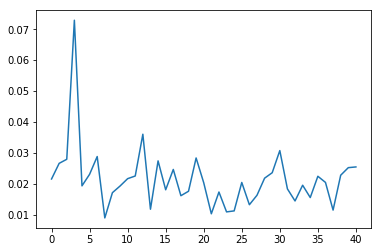

In [20]:
scores = []
for i in range(len(x_days)):
    pred = mlp_model.predict(x_days[i])
    scores.append(score(y_days[i], pred))
plt.plot(scores)
plt.show()

In [ ]:
pred = mlp_model.predict(x)

In [25]:
score(y, pred)

0.024617373943328857

In [26]:
for i in range(20):
    s = 0.25 * i
    flag = np.abs(y) != s
    print(s, score(y[flag], pred[flag]))

0.0 0.027246594429016113
0.25 0.026433050632476807
0.5 0.025861144065856934
0.75 0.02553623914718628
1.0 0.024115025997161865
1.25 0.02461177110671997
1.5 0.024286508560180664
1.75 0.02474004030227661
2.0 0.02425968647003174
2.25 0.02457261085510254
2.5 0.024411141872406006
2.75 0.024487614631652832
3.0 0.02432548999786377
3.25 0.024287283420562744
3.5 0.024195313453674316
3.75 0.024409711360931396
4.0 0.024206876754760742
4.25 0.023826420307159424
4.5 0.02443784475326538
4.75 0.024279773235321045


#### vis by day

In [83]:
time_steps, norm_window_size, levels = 15, 1, 5 
ask_rate = np.log10(dataset.features[..., 15:15+levels])
bid_rate = np.log10(dataset.features[..., 45:45+levels])
x = np.concatenate([ask_rate, bid_rate], axis=-1)
x, y = data_sliding(x, dataset.label_y, time_step=time_steps+norm_window_size-1)

In [96]:
start_ind = 0

# scores = []
stds = []
means = []
for i in range(1, len(dt.days_index)):
    num = dt.days_index[i] - dt.days_index_nonzero[i-1]
    dx = x[start_ind:start_ind+num]
    dy = y[start_ind:start_ind+num]
    start_ind += num
    
#     dx_pred = mlp_model.predict(dx)
#     scores.append(score(dy, dx_pred))
    
    means.append(np.mean(dy))
    stds.append(np.std(dy))

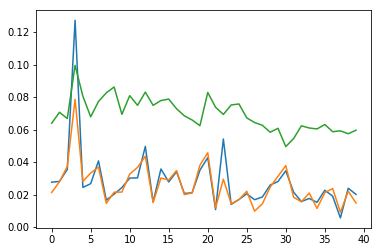

In [95]:
plt.plot(scores)
plt.plot(scores1)
# plt.plot(means)
plt.plot(stds)
plt.show()

In [82]:
scores1 = copy.deepcopy(scores)

In [97]:
for s0, s1 in zip(scores, stds):
    print(s0, s1)

0.027571558952331543 0.6384002
0.028066813945770264 0.7061517
0.03540921211242676 0.667396
0.1272495985031128 0.9949269
0.024376273155212402 0.804973
0.026668667793273926 0.67802316
0.0406915545463562 0.7728905
0.016563475131988525 0.82540905
0.020204246044158936 0.86180985
0.02424442768096924 0.693406
0.030104875564575195 0.8085211
0.03024113178253174 0.74881685
0.04960942268371582 0.8302861
0.015388786792755127 0.74866843
0.03569996356964111 0.7784372
0.02773427963256836 0.7872162
0.03400653600692749 0.7279955
0.02064114809036255 0.68432295
0.02107071876525879 0.658384
0.03499341011047363 0.62373334
0.0426863431930542 0.82812816
0.010708749294281006 0.73694396
0.05414825677871704 0.6928141
0.013879239559173584 0.7511822
0.016940653324127197 0.75722116
0.020452439785003662 0.67135996
0.016805529594421387 0.6430727
0.01847994327545166 0.62589127
0.025823652744293213 0.5833055
0.02800995111465454 0.60746
0.03461718559265137 0.49497283
0.021445155143737793 0.5442063
0.0156402587890625 0.

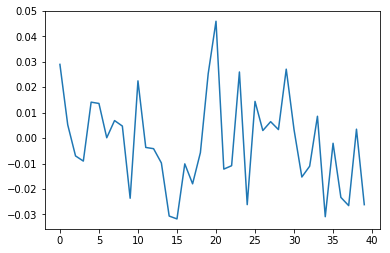

In [36]:
plt.plot(means)
plt.show()

In [49]:
for s, m in zip(scores, means):
    print(s, m)

0.02123051881790161 0.029015044
0.027868688106536865 0.005257429
0.037263453006744385 -0.006992725
0.07858496904373169 -0.009026358
0.028115570545196533 0.014151495
0.033209800720214844 0.013647265
0.03684574365615845 0.00014587094
0.014543414115905762 0.0069083525
0.02140963077545166 0.0047514066
0.021494746208190918 -0.023647927
0.03256100416183472 0.022530537
0.036650657653808594 -0.0036627168
0.04353684186935425 -0.0041483194
0.015096485614776611 -0.009762233
0.030155181884765625 -0.030655978
0.028970718383789062 -0.031777583
0.0347599983215332 -0.010121351
0.01995760202407837 -0.017969761
0.020962119102478027 -0.0056992965
0.038090527057647705 0.025349882
0.04568374156951904 0.045983765
0.011790871620178223 -0.012184419
0.029454350471496582 -0.010848749
0.01427990198135376 0.026025303
0.01688528060913086 -0.026160095
0.02202022075653076 0.014455603
0.0097389817237854 0.0029855436
0.014294624328613281 0.006476601
0.024552881717681885 0.003367902
0.031228482723236084 0.027130317
0.0